# Imports & Setup

In [1]:
import logging, random, itertools, time, copy, math
from typing import Iterable
import IPython.display

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import nltk
# from modAL.models import ActiveLearner, Committee
# from modAL.uncertainty import entropy_sampling
# from modAL.disagreement import KL_max_disagreement
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import sklearn.linear_model, sklearn.neighbors, sklearn.ensemble, sklearn.svm, sklearn.cluster, sklearn.mixture, sklearn.feature_extraction, sklearn.model_selection, sklearn.preprocessing, sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans, HDBSCAN, OPTICS, Birch
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
#from skmultilearn.model_selection import iterative_train_test_split
import pke
import spacy
#from wordcloud import WordCloud
import torch
from torch import nn
from transformers import logging as transformerslogging
from transformers import BertModel, BertTokenizer, pipeline
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from torchsummary import summary

from utils import to_unixtime, to_clocktime, full_preprocess, light_preprocess, \
                  IDF, TF_IDF, RBipolarDatasetBuilder, ListDataset, w2vAverager, BertVectorizer, \
                  TFIDFVectorizerWrapper, FocalLoss, train, evaluate, train_topicmtm, evaluate_topic

C:\Users\aalon_przcr8o\mambaforge\envs\vt\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\aalon_przcr8o\mambaforge\envs\vt\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\aalon_przcr8o\mambaforge\envs\vt\Lib\site-packages\umap\distances.py:

In [2]:
%load_ext autoreload
%aimport utils
%autoreload 1

In [3]:
random.seed(539144) # from random.org
HOME = "D:/Python/VTech/"            
logging.basicConfig(
    filename = HOME+"project.log", 
    filemode = "w",
    format = "[%(asctime)s] %(name)s (%(levelname)s): %(message)s", 
    datefmt = "%m/%d-%H:%M:%S", 
    level = logging.DEBUG,
    force = True,
)
transformerslogging.set_verbosity_error()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device", device, torch.cuda.get_device_name())

Using device cuda NVIDIA GeForce RTX 3070 Laptop GPU


# Main Model

In [4]:
class MultiTaskModule(torch.nn.Module):
    ''' works for hard-sharing and soft-sharing parameters '''
    def __init__(self, task_module: nn.Module, n_tasks: int=1):
        super().__init__()
        self.n_tasks = n_tasks
        self.task_modules = nn.ModuleList([copy.deepcopy(task_module) for task in range(self.n_tasks)])
        with torch.no_grad(): # TODO try removing
            for param in self.task_modules.parameters():
                if param.requires_grad:
                    nn.init.uniform_(param, -1.0, 1.0)
        self.combinations = [pair for pair in itertools.combinations(range(self.n_tasks), 2)]
        
    def forward(self, x) -> torch.Tensor:
        return torch.stack([task_module(x).squeeze() for task_module in self.task_modules], dim=1)
        
    @staticmethod
    def L1_distance(A: nn.Module, B: nn.Module, p=-1) -> torch.Tensor:
        ''' Absolute distance between params/Lasso regularization; sum( A-B ) '''
        d = torch.zeros(1).to(device)
        for p1, p2 in zip(A.parameters(), B.parameters()):
            if p1.requires_grad and p2.requires_grad:
                d += (p1.sub(p2)).abs().sum()
        return d
    
    @staticmethod
    def L2_distance(A: nn.Module, B: nn.Module, group_lasso=False,p=-1) -> torch.Tensor:
        ''' Euclidean distance between params/Ridge regularization; sqrt( sum( (A-B)^2 ) ) '''
        d = torch.zeros(1).to(device)
        for p1, p2 in zip(A.parameters(), B.parameters()):
            if p1.requires_grad and p2.requires_grad:
                d += p1.dist(p2) #* (math.sqrt(p1.numel()) if group_lasso else 1)
        return d
    
    def multitask_regularization_loss(self, p: int=2, task_idx: int=None) -> torch.Tensor: #TODO depth-varying
        loss = torch.zeros(1).to(device)
        if p == 1: distance = MultiTaskModule.L1_distance
        elif p == 2: distance = MultiTaskModule.L2_distance
        else: distance = MultiTaskModule.Lp_distance
        if task_idx is None:
            for i1, i2 in self.combinations:
                loss += distance(self.task_modules[i1], self.task_modules[i2], p=p)
        else:
            for i in range(self.n_tasks):
                if i != task_idx:
                    loss += distance(self.task_modules[task_idx], self.task_modules[i], p=p)
        return loss

class SharedFeatureModule(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(32, 128, kernel_size=3, padding=1)
        self.dense = nn.Sequential(
            nn.Linear(384, 16), nn.ReLU(), nn.Dropout(0.5),
        )
        self.dropout = nn.Dropout(0)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        # self.avgpool = nn.AdaptiveAvgPool1d(6)
    
    def forward(self, x):
        x = x.unsqueeze(1)
        out = self.dropout(self.conv1(x))
        # out = self.dropout(self.conv2(out))
        out = out.mean(dim=1, keepdim=False)
        #print(out.shape
        # out = out.flatten(start_dim=1)
        out = self.dense(out)
        return out

class TaskSpecificModule(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dense = nn.Sequential(
            #nn.Linear(399, 32), nn.ReLU(),
            nn.Linear(26, 18), nn.ReLU(), nn.Dropout(0.5),
            #nn.Linear(64, 32), nn.ReLU(),
          #  nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(18, 1),# nn.Sigmoid(), 
        )
    
    def forward(self, x):
        # print(x.shape)
        out = self.dense(x)
        return out

class ConvMLP_MTM(torch.nn.Module):
    def __init__(self, n_tasks=3, n_topics=10, task_alphas: tuple[float]=(1,1,1), joint_beta: float=0, focal_gamma: float=2, reg_delta: float=0, reg_epsilon: float=0):
        super().__init__()
        self.shared = SharedFeatureModule()
        self.multitask = MultiTaskModule(TaskSpecificModule(), n_tasks)
        self.fc1 = nn.Linear(n_topics, 10) # ---------------------------------------------------------
        #self.task_alphas = nn.Parameter(torch.Tensor(task_alphas), requires_grad=False)
        # self.task_loss = nn.BCEWithLogitsLoss(weight=self.task_alphas)
        self.task_loss = nn.BCEWithLogitsLoss(weight=torch.Tensor(task_alphas))
        self.joint_loss = FocalLoss(gamma=focal_gamma)#, alpha=task_alphas)
        self.joint_beta = nn.Parameter(torch.Tensor([joint_beta]), requires_grad=False)
        self.mtmreg_delta = nn.Parameter(torch.Tensor([reg_delta]), requires_grad=False)
        self.reg_epsilon = nn.Parameter(torch.Tensor([reg_epsilon]), requires_grad=False)
        #print(self.joint_beta, self.mtmreg_delta, self.reg_epsilon)
    
    def forward(self, x, topic_vec):
        out = x
        out = self.shared(out)
        topic_vec = nn.functional.relu(self.fc1(topic_vec))
        out = torch.cat((out, topic_vec), dim=1)
        out = self.multitask(out)
        # out = self.multitask((x, topic_vec))
        return out
    
    def reg_loss(self, p=2):
        l = torch.zeros(1).to(device)
        for param in self.parameters():
            if param.requires_grad:
                l += param.norm(p) #* math.sqrt(param.numel())
        return l
    
    def calc_loss(self, output, truth):
        joint_loss = self.joint_loss(output, truth) * self.joint_beta
        # task_loss = torch.zeros(1).to(device)
        task_loss = self.task_loss(output, truth)
        # for y_out, y_truth, alpha in zip(output, truth, self.alphas):
        #     task_loss += self.task_loss(y_out, y_truth) * alpha
        mtmreg_loss = self.multitask.multitask_regularization_loss(p=2, task_idx=None) * self.mtmreg_delta
        reg_loss = self.reg_loss(p=1) * self.reg_epsilon
        # print(self.joint_beta, self.mtmreg_delta)
        # print(task_loss, joint_loss, mtmreg_loss, reg_loss)
        return task_loss + joint_loss + mtmreg_loss + reg_loss

class ConvMLP_soft(ConvMLP_MTM):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        del self.shared
        self.multitask = MultiTaskModule(SharedFeatureModule(), n_tasks=3)
        self.mlps = nn.ModuleList([TaskSpecificModule() for t in range(3)])
    
    def forward(self, x, topic_vec):
        out = self.multitask(x)
        topic_vec = nn.functional.relu(self.fc1(topic_vec))
        out = [self.mlps[t](torch.cat((out[:, t], topic_vec), dim=1)) for t in range(3)]
        # out = [self.mlps[t](out[:, t]) for t in range(3)]
        return torch.stack(out).squeeze().transpose(0, 1)

# Data

## Extract, Balance, and Save a Dataset

In [447]:
def make_dataset():
    portion = 216
    order = ['created_utc','id','selftext','title','subreddit','anxiety','bipolar','depression']

    df0 = pd.read_excel("D:/Python/VTech/bysubredditdata/rbipolar_0-2000_3001-3803_5001-6000.xlsx",header=0, index_col=0).iloc[:2001]
    #df = df.iloc[np.r_[0:2001, 5001:5931], [1,2,3,4,5,7,8,9]]
    #df = df.sample(frac=1)
    # df0 = pd.DataFrame(columns=order)
    # a, b, d, z = 0,0,0,0
    # for idx, row in df.iterrows():
    #     anx, dep, bip = row[['anxiety', 'depression', 'bipolar']]
    #     if anx == 1 or dep == 1:
    #         df0.loc[len(df0.index)] = row
    #     elif anx == 0 and dep == 0 and bip == 0:
    #         z += 1
    #         if z <= portion:
    #             df0.loc[len(df0.index)] = row
    #print(a, b, d, z)
    a, b, d, z = 0,0,0,0
    for idx, row in df0.iterrows():
        if row['anxiety'] == 1: a += 1
        if row['bipolar'] == 1: b += 1
        if row['depression'] == 1: d += 1
        if row['anxiety']==0 and row['bipolar']==0 and row['depression']==0: z += 1
    print(a, b, d, z)

    df1 = pd.read_excel(HOME+"bysubredditdata/rbipolar_3501-3850_Rocco.xlsx", header=0, index_col=0)
    
    # Control
    # df1 = pd.read_csv("D:/Python/VTech/bysubredditdata/raskreddit_1M2021.csv")
    # df1['subreddit'] = "askreddit"
    # df1['anxiety'] = 0; df1['bipolar'] = 0; df1['depression'] = 0;
    # df1 = df1[order]
    # df1 = df1.sample(portion)
    
    # df2 = pd.read_csv("D:/Python/VTech/bysubredditdata/rjokes_1M2015-2020.csv")
    # df2['subreddit'] = "jokes"
    # df2['anxiety'] = 0; df2['bipolar'] = 0; df2['depression'] = 0;
    # df2 = df2[order]
    # df2 = df2.sample(portion)
    
    # df3 = pd.read_excel("D:/Python/VTech/bysubredditdata/rcozyplaces&rcasualconversation&etc_2021&2022.xlsx")# 4 subreddits
    # df3.rename(columns={"date":"created_utc","text":"selftext"}, inplace=True)
    # df3['title'] = "removed" # will get removed in processing
    # df3['subreddit'] = 'cozyplaces,CasualConversation,etc.'
    # df3['anxiety'] = 0; df3['bipolar'] = 0; df3['depression'] = 0;
    # df3 = df3[order]
    # df3 = df3.sample(3*portion)
    
    collective = pd.concat([df0, df1,])# df2, df3])
    collective.reset_index(inplace=True)
    collective.drop(columns='index', inplace=True)
    
    a, b, d, z = 0,0,0,0
    for idx, row in collective.iterrows():
        anx, dep, bip = row[['anxiety', 'depression', 'bipolar']]
        if anx == 1: a += 1
        if bip == 1: b += 1
        if dep == 1: d += 1
        if anx==0 and bip == 0 and dep == 0: z += 1
    print("count of anxiety, bipolar, depression, none:",a,b,d,z)
    
    collective.to_excel(HOME+"data/RoccoUnbalanced/dataset_2351.xlsx")
    return

In [449]:
make_dataset()
# df = pd.read_csv("D:/Python/VTech/bysubredditdata/rbipolar_2020&2021.csv")
# df = df.iloc[ np.r_[0:2001,5001:6001] , [1,2,3,"4,5,6,8,9,10] ]
# df.to_csv("D:/Python/VTech/data/rbipolar_2020&2021-LABELED.csv")

273 1281 311 553
count of anxiety, bipolar, depression, none: 326 1482 378 663


## Create and Save Embeddings

In [77]:
dataroot = HOME+"data/AllUnbalanced/"
dataset = RBipolarDatasetBuilder(file_path = dataroot+"dataset_3804.xlsx")

### TF-IDF

In [8]:
def make_tfidf():
    dataset.preprocess = full_preprocess; dataset.vectorizer = None; dataset.n_grams = 0
    tfidf = TfidfVectorizer()
    tfidf.fit([' '.join(sample[0]) for sample in dataset])
    dataset.vectorizer = TFIDFVectorizerWrapper(tfidf)
    print("Saving TF-IDFs")
    torch.save([(vec, label) for vec, label in tqdm(dataset)], HOME+"data/tfidf_embeddings.pt")

### doc2vec

In [270]:
def make_doc2vec():
    dataset.preprocess = full_preprocess; dataset.vectorizer = None; dataset.n_grams = 0
    d2v = Doc2Vec(
        documents = [ TaggedDocument(sample[0], [i]) for i,sample in enumerate(dataset) ],
        vector_size = 200,
        epochs = 69,
    )
    d2v.save("D:/Python/VTech/models/Doc2Vec_v3")
    d2v = Doc2Vec.load("D:/Python/VTech/models/Doc2Vec_v3")
    dataset.vectorizer = d2v.infer_vector
    print("Saving doc2vecs")
    torch.save([(vec, label) for vec, label in tqdm(dataset)], HOME+"data/doc2vec_embeddings.pt")

### word2vec + Average

In [10]:
def make_word2vecavg():
    dataset.preprocess = full_preprocess; dataset.vectorizer = None; dataset.n_grams = 0
    # w2v = Word2Vec(
    #     sentences = [sample[0] for sample in dataset],
    #     vector_size = 200,
    #     epochs = 69,
    # )
    # w2v.save("D:/Python/VTech/models/Word2Vec_v2")
    w2v = Word2Vec.load(HOME+"models/Word2Vec_v2")
    dataset.vectorizer = w2vAverager(w2v.wv)
    print("Saving word2vec avgs")
    torch.save([(vec, label) for vec, label in tqdm(dataset)], HOME+"data/word2vecavg_embeddings.pt")

### BERT + Average

In [563]:
def make_BERTavg():
    dataset.preprocess = light_preprocess; dataset.vectorizer = None; dataset.n_grams = 1
    bert = BertModel.from_pretrained('bert-base-uncased').to(device)
    #bert = BertModel.from_pretrained("D:/Python/VTech/models/BERTModel")
    bert.eval()
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    #tokenizer = BertTokenizer.from_pretrained("D:/Python/VTech/models/BERTTokenizer")
    dataset.vectorizer = BertVectorizer(bert, tokenizer, device)
    with torch.no_grad():
        print("Saving BERT avgs")
        cpu = torch.device('cpu')
        torch.save([(vec.to(cpu), label.to(cpu)) for vec, label in tqdm(dataset)], dataroot+"BERTavg_embeddings.pt")

### Sentence-BERT

In [78]:
def make_SBERT():
    dataset.preprocess = light_preprocess; dataset.vectorizer = None; dataset.n_grams = 1
    sbert = SentenceTransformer('all-MiniLM-L6-v2')
    # sbert = SentenceTransformer.load("D:/Python/VTech/models/SBERTModel")
    texts = []
    labels = []
    for text, label in dataset:
        texts.append(text)
        labels.append(label)
    print("Encoding...",end='\r')
    vecs = sbert.encode(dataset, show_progress_bar=True, convert_to_numpy=False, device=torch.device('cuda'))
    print("Saving...", end='\r')
    torch.save([(vec.squeeze(),label) for vec,label in zip(vecs, labels)], dataroot+"SBERT_embeddings.pt")

### Embeddings

In [79]:
# make_tfidf()
# make_doc2vec()
# make_word2vecavg()
# make_BERTavg()
make_SBERT()

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

In [5]:
df = pd.read_excel(HOME+"data/AllBalanced/dataset_1847.xlsx")

In [6]:
ta,tb,td,tc, tob,tbd = 0,0,0,0,0,0
ob, oc, bd = [],[],[]
for i,row in df.iterrows():
    a,b,d = row.loc['anxiety'], row.loc['bipolar'], row.loc['depression']
    ta += a; tb += b; td += d
    if a==0 and b==0 and d==0: tc += 1; oc.append(i)
    elif a==0 and b==1 and d==0: tob += 1; ob.append(i)
    elif a==0 and b==1 and d==1: tbd += 1; bd.append(i)
print(ta,tb,td,tc, tob,tbd)

534 817 631 747 150 250


In [554]:
drops = []
for i in ob:
    if random.random() < 0.906:
        drops.append(i)
for i in oc:
    if random.random() < 0.66:
        drops.append(i)
# for i in bd:
#     if random.random() < 0.4:
#         drops.append(i)

In [556]:
df = df.drop(drops)

In [560]:
df.to_excel(HOME+"data/AllBalanced/dataset_1847.xlsx")

## Load Data

In [5]:
dataroot = HOME+"data/AllUnbalanced/"
data = torch.load(dataroot+"SBERT_embeddings.pt")
# raw_text = [ str(row['text']) for _,row in pd.read_csv(HOME+"data/RoccoShailikBalanced/dataset_2000.csv").iterrows() ]
raw_text = [ str(row['title'])+" "+str(row['selftext'])
                for i,row in pd.read_excel(dataroot+"dataset_3804.xlsx").loc[:,['selftext','title']].iterrows() ]
_temp = list(zip(data, raw_text))
random.shuffle(_temp)
data, raw_text = zip(*_temp)
xEmbeddings = [emb for emb,label in data]
yLabels = [label for emb,label in data]
print(len(xEmbeddings), "total data points")
print("Embeddings are of type", type(xEmbeddings[0]), "with shape", xEmbeddings[0].shape)
print(raw_text[0], yLabels[0])

3804 total data points
Embeddings are of type <class 'torch.Tensor'> with shape torch.Size([384])
Every day in summer nan tensor([0., 0., 0.])


## Topic Modeling

In [8]:
# processor = RBipolarDatasetBuilder(preprocess = full_preprocess, vectorizer = None)
docs = [full_preprocess(raw) for raw in raw_text]
topic_model = BERTopic(calculate_probabilities=True, nr_topics=20+1) # +1 for control topic
print(docs[100])

lexapro day manic episode prescribed lexapro yesterday took first time today feel amped think normal zero drug atm feel like cocaine took probably hour ago hand jaw teeth chattering literally shaking able sit still feel like explode know add taken adderall past feel different fidgeting feel like sober even right like giggling absolutely nothing hard explain example went get food starving came downstairs different item made food collection room stoned acting high acid literally cant settle relax giddy stomach hurt tense cold hour even got jacked excited punched multiple time head face never done far le tactful cant get stupid shit eating grin face also read le horny usual anything caffeine earlier mixed lexapro manic episode normal lexapro feel far wired adderall tell truth


In [9]:
topics, xTopics = topic_model.fit_transform(docs)
print(xTopics[0])
topic_model.get_topic_info()

[0.31763425 0.07188062 0.03733024 0.03435337 0.01701704 0.0526077
 0.03708727 0.09912914 0.01332467 0.02043027 0.02382218 0.01966409
 0.00562048 0.01750027 0.08648133 0.03177683 0.03201777 0.01984698
 0.01130443 0.01405559]


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1792,-1_like_feel_know_get,"[like, feel, know, get, time, bipolar, really,...",[finding bipolar stability friend hope well ta...
1,0,790,0_feel_like_bipolar_know,"[feel, like, bipolar, know, get, time, want, r...",[grandfather diagnosed father diagnosed third ...
2,1,307,1_bipolar_manic_mania_disorder,"[bipolar, manic, mania, disorder, music, mood,...","[bipolar, bipolar, bipolar]"
3,2,201,2_lamictal_seroquel_weight_latuda,"[lamictal, seroquel, weight, latuda, anyone, e...",[seroquel weight gain trouble sleeping psychia...
4,3,156,3_sleep_hypomanic_hypomania_night,"[sleep, hypomanic, hypomania, night, hour, dre...",[weird sleep schedule hello diagnosed fyi anyw...
5,4,69,4_med_pharmacy_medication_take,"[med, pharmacy, medication, take, monday, girl...","[take med, med, med]"
6,5,66,5_art_painting_artwork_drew,"[art, painting, artwork, drew, draw, drawing, ...",[officially opened art commission already four...
7,6,63,6_help_gang_test_carrot,"[help, gang, test, carrot, downvote, screech, ...","[gang, need help, need help]"
8,7,60,7_love_feel_pain_else,"[love, feel, pain, else, lost, feeling, heart,...",[lost cant control thought year old feel like ...
9,8,52,8_sex_birth_hypersexuality_sexual,"[sex, birth, hypersexuality, sexual, control, ...",[dealing hyper sexuality pretty stable med pha...


## Label Smoothing

In [10]:
epsilon = 0.05
skew = 0.
yLabelsSmoothed = [
    (onehot_labels - epsilon).where(onehot_labels >= 0.5, onehot_labels + epsilon) + skew
    for onehot_labels in yLabels
]

print("One Hot:", yLabels[0], ", Smoothed:",yLabelsSmoothed[0])

One Hot: tensor([0., 0., 0.]) , Smoothed: tensor([0.0500, 0.0500, 0.0500])


# Training & Evaluation

## Data

In [6]:
emb_scaler = StandardScaler()
topic_scaler = StandardScaler()
xnpEmbeddings = [x_.cpu().numpy()for x_ in xEmbeddings]
# xnpEmbeddings = xEmbeddings

In [11]:
trainval_splitidx = int(len(xEmbeddings)*0.85)
# train_x = [sample[0].to_dense().squeeze() for sample in train_data] # when loading tfidf embeddings
# val_x = [sample[0].to_dense().squeeze() for sample in val_data]
print(xnpEmbeddings[0].shape)
xTrainEmbeddingsScaled = emb_scaler.fit_transform(xnpEmbeddings[:trainval_splitidx])
xValEmbeddingsScaled = emb_scaler.transform(xnpEmbeddings[trainval_splitidx:])
xTrainTopicsScaled = topic_scaler.fit_transform(xTopics[:trainval_splitidx])
xValTopicsScaled = topic_scaler.transform(xTopics[trainval_splitidx:])

yTrain = [label.numpy() for label in yLabelsSmoothed[:trainval_splitidx]]
yTrainByTask = [ [(label[task] >= 0.5).astype(np.int32) for label in yTrain] for task in range(3) ] # turn back to one-hot
yVal = [label.numpy() for label in yLabelsSmoothed[trainval_splitidx:]]
yValByTask = [ [(label[task] >= 0.5).astype(np.int32) for label in yVal] for task in range(3) ]

(384,)


## Comparison Models

### Non-backprop

#### Models

In [87]:
logreg, svm, knn, rdmforest = [],[],[],[]
for task in range(3):
    logreg.append(sklearn.linear_model.LogisticRegression(C=0.01, max_iter=1000))
    svm.append(sklearn.svm.SVC(C=1.1, kernel="rbf"))
    knn.append(sklearn.neighbors.KNeighborsClassifier(n_neighbors=5))
    rdmforest.append(sklearn.ensemble.RandomForestClassifier(n_estimators=20))

#### Training and Evaluation

In [88]:
for task in range(3):
    traintask_y = yTrainByTask[task]
    logreg[task].fit(np.concatenate((xTrainEmbeddingsScaled, xTrainTopicsScaled), axis=1), traintask_y)
    knn[task].fit(np.concatenate((xTrainEmbeddingsScaled, xTrainTopicsScaled), axis=1), traintask_y)
    svm[task].fit(np.concatenate((xTrainEmbeddingsScaled, xTrainTopicsScaled), axis=1), traintask_y)
    rdmforest[task].fit(np.concatenate((xTrainEmbeddingsScaled, xTrainTopicsScaled), axis=1), traintask_y)
    # logreg[task].fit(xTrainEmbeddingsScaled, traintask_y)
    # knn[task].fit(xTrainEmbeddingsScaled, traintask_y)
    # svm[task].fit(xTrainEmbeddingsScaled, traintask_y)
    # rdmforest[task].fit(xTrainEmbeddingsScaled, traintask_y)

In [89]:
for model, name in zip([logreg, knn, rdmforest, svm], ["Logistic Regression","KNN","Random Forest","SVM"]):
    print(f"{name:-^60}")
    macro_avg2, acc, micro_avg2 = 0,0,0
    input_ = np.concatenate((xValEmbeddingsScaled, xValTopicsScaled), axis=1)
    # input_ = xValEmbeddingsScaled
    # print("Task 0: Anxiety")
    for t in range(3):
        report = classification_report(yValByTask[t], model[t].predict(input_), digits=4, output_dict=True)
        acc += report['accuracy']
        macro_avg2 += report['macro avg']['f1-score']
        micro_avg2 += report['weighted avg']['f1-score']
    # print("Task 1: Bipolar")
    # report1 = classification_report(yValByTask[1], model[1].predict(input_), digits=4, target_names=["Bipolar", "Null"], output_dict=True)
    # acc += report1['accuracy']
    # macro_avg2 += report1['macro avg']['f1-score']
    # micro_avg2 += report1['weighted avg']['f1-score']
    # # print("Task 2: Depression")
    # report2 = classification_report(yValByTask[2], model[2].predict(input_), digits=4, target_names=["Depression", "Null"], output_dict=True)
    # acc += report2['accuracy']
    # macro_avg2 += report2['macro avg']['f1-score']
    # micro_avg2 += report2['weighted avg']['f1-score']

    print("Average Acc:", acc / 3)
    print("Average Macro Average F1 Score:", macro_avg2 / 3)
    print("Average Micro Average F1 Score:", micro_avg2 / 3)
    # print(report0)
    # print(report1)
    # print(report2)

--------------------Logistic Regression---------------------
Average Acc: 0.8955049620548746
Average Macro Average F1 Score: 0.8285999804613312
Average Micro Average F1 Score: 0.8908374600520489
----------------------------KNN-----------------------------
Average Acc: 0.837711617046118
Average Macro Average F1 Score: 0.7356958844708551
Average Micro Average F1 Score: 0.8321596707354075
-----------------------Random Forest------------------------
Average Acc: 0.8307063631056626
Average Macro Average F1 Score: 0.6643626867024818
Average Micro Average F1 Score: 0.804499596182798
----------------------------SVM-----------------------------
Average Acc: 0.8814944541739638
Average Macro Average F1 Score: 0.785406909820105
Average Micro Average F1 Score: 0.8715645007302681


### Backprop

#### Separate Model

Begining Training of Separate MLPs...


Training; Loss: 0.361 Val Acc: 85.70%: 100%|█████████████████████████████████████████| 50/50 [00:02<00:00, 17.09it/s]


Training completed in 0m 3s
Final Training Accuracy: 96.05%
Final Validation Accuracy: 85.70%


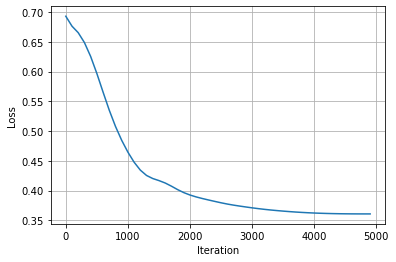

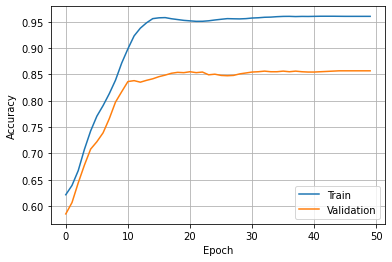

0.8569760653823701 0.7780501234483784 0.8509314787980468


In [568]:
class SeparateMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.separate_mlps = nn.ModuleList([nn.Sequential(
            nn.Linear(384, 16), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(16, 1), #nn.Sigmoid(),
        ) for _ in range(3)])
        self.bceloss = nn.BCEWithLogitsLoss(weight=torch.Tensor([1,1,1]))
        
    def forward(self, x):
        return torch.stack([mlp(x).squeeze() for mlp in self.separate_mlps], dim=1)
    
    def loss(self, truth, pred):
        l = torch.zeros(1).to(device)
        l += self.bceloss(truth, pred)
        #l += self.separate_loss() * 0.00
        return l
    
    def separate_loss(self):
        l = torch.zeros(1).to(device)
        for i1, i2 in itertools.combinations(range(3), 2):
            l += MultiTaskModule.L2_distance(self.separate_mlps[i1], self.separate_mlps[i2])
        return l

if True and __name__=="__main__":    
    macro_avg2 = 0
    train_data = ListDataset([ 
        # (torch.cat((torch.from_numpy(emb).float(),torch.from_numpy(topic).float())), label) 
        (torch.from_numpy(emb).float(), label) 
        for emb,topic,label in zip(xTrainEmbeddingsScaled, xTrainTopicsScaled, yTrain) 
    ])
    val_data = ListDataset([ 
        # (torch.cat((torch.from_numpy(emb).float(), torch.from_numpy(topic).float())), label) 
        (torch.from_numpy(emb).float(), label) 
        for emb,topic,label in zip(xValEmbeddingsScaled, xValTopicsScaled, yVal) 
    ])
    model = SeparateMLP()
    #summary(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=3e-3)
    #optimizer = torch.optim.SGD(model.parameters(), lr=1)
    criterion = model.loss
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, epochs=50, steps_per_epoch=1)
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=(2000,3000,4000), gamma=0.2)
    model = train(
        model_name = f"Separate MLPs",
        model = model, 
        train_data = train_data,
        val_data = val_data,
        criterion = criterion,
        optimizer = optimizer, 
        scheduler = scheduler,
        num_epochs = 50,
        batch_size = 10000,
        device = device,
        verbose = False, # False is still verbose, just less
    )

    model.cpu()
    x_val = torch.stack([ x for x,y in val_data ] )
    y_val = (torch.Tensor([ y for x,y in val_data ]) >= 0.5).int()
    model_preds = (torch.sigmoid(model(x_val)) >= 0.5).int()
    report_acc, macro_avg2, micro_avg2 = 0,0,0
    for t in range(3):
        report = classification_report(y_val[:,t], model_preds[:,t], output_dict=True)
        report_acc += report['accuracy']
        macro_avg2 += report['macro avg']['f1-score']
        micro_avg2 += report['weighted avg']['f1-score']
    print(report_acc/3, macro_avg2/3, micro_avg2/3)

#### Merged Model

Begining Training of Merged MLP...


Training; Loss: 0.473 Val Acc: 84.88%: 100%|█████████████████████████████████████████| 50/50 [00:02<00:00, 19.50it/s]


Training completed in 0m 3s
Final Training Accuracy: 95.61%
Final Validation Accuracy: 84.88%


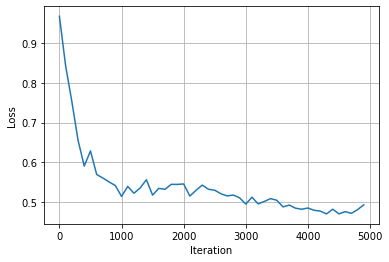

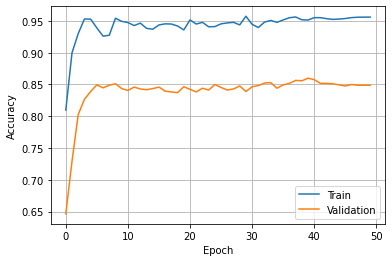

0.8488032691185055 0.756717878200586 0.8410149118989532


In [530]:
if True and __name__=="__main__":
    merged_mlp = nn.Sequential(
        nn.Linear(384, 48), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(48, 3), #nn.Sigmoid(),
    )
    macro_avg2 = 0
    train_data = ListDataset([ 
        # (torch.cat((torch.from_numpy(emb).float(),torch.from_numpy(topic).float())), label) 
        (torch.from_numpy(emb).float(), label) 
        for emb,topic,label in zip(xTrainEmbeddingsScaled, xTrainTopicsScaled, yTrain) 
    ])
    val_data = ListDataset([ 
        # (torch.cat((torch.from_numpy(emb).float(),torch.from_numpy(topic).float())), label) 
        (torch.from_numpy(emb).float(), label) 
        for emb,topic,label in zip(xValEmbeddingsScaled, xValTopicsScaled, yVal) 
    ])
    model = merged_mlp
    #summary(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
    #optimizer = torch.optim.SGD(model.parameters(), lr=1)
    criterion = nn.BCEWithLogitsLoss(weight=torch.Tensor([2,0.3,2]).to(device))
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=3e-2, epochs=50, steps_per_epoch=1)
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=(2000,3000,4000), gamma=0.2)
    model = train(
        model_name = f"Merged MLP",
        model = model, 
        train_data = train_data,
        val_data = val_data,
        criterion = criterion,
        optimizer = optimizer, 
        scheduler = scheduler,
        num_epochs = 50,
        batch_size = 1024,
        device = device,
        verbose = False, # False is still verbose, just less
    )

    model.cpu()
    x_val = torch.stack([ x for x,y in val_data ] )
    y_val = (torch.Tensor([ y for x,y in val_data ]) >= 0.5).int()
    model_preds = (torch.sigmoid(model(x_val)) >= 0.5).int()
    report_acc, macro_avg2, micro_avg2 = 0,0,0
    for t in range(3):
        report = classification_report(y_val[:,t], model_preds[:,t], output_dict=True)
        report_acc += report['accuracy']
        macro_avg2 += report['macro avg']['f1-score']
        micro_avg2 += report['weighted avg']['f1-score']
    print(report_acc/3, macro_avg2/3, micro_avg2/3)

#### Multi-task Model

In [28]:
class MultiTaskMLP(nn.Module):
    def __init__(self, n_tasks=3):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(384, 24), nn.ReLU(), nn.Dropout(0.5),
           # nn.Linear(32, 16), nn.ReLU(), nn.Dropout(0.5),
        )
        self.task_modules = nn.ModuleList([
            nn.Sequential(
                nn.Linear(39, 16), nn.ReLU(), nn.Dropout(0.5),
                nn.Linear(16, 1), #nn.Sigmoid(),
            ) 
            for task in range(n_tasks)
        ])
        self.fc1 = nn.Linear(20, 15)
        self.bceloss = nn.BCEWithLogitsLoss(weight=torch.Tensor([2,0.3,2]))
        self.joint_loss = FocalLoss(gamma=2)
    
    def forward(self, x, topic):
        out = self.shared(x)
        topic = nn.functional.relu(self.fc1(topic))
        out = torch.cat([out, topic], dim=1)
        #print(out.shape)
        out = torch.stack([task_module(out).squeeze() for task_module in self.task_modules], dim=1)
        return out
    
    def loss(self, truth, pred):
        l = torch.zeros(1).to(device)
        l += self.bceloss(truth, pred)
        l += self.joint_loss(pred, truth) * 1
        return l

##### Training and Evaluation

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 24]           9,240
              ReLU-2                   [-1, 24]               0
           Dropout-3                   [-1, 24]               0
            Linear-4                   [-1, 15]             315
            Linear-5                   [-1, 16]             640
              ReLU-6                   [-1, 16]               0
           Dropout-7                   [-1, 16]               0
            Linear-8                    [-1, 1]              17
            Linear-9                   [-1, 16]             640
             ReLU-10                   [-1, 16]               0
          Dropout-11                   [-1, 16]               0
           Linear-12                    [-1, 1]              17
           Linear-13                   [-1, 16]             640
             ReLU-14                   

Training; Loss: 0.560 Val Acc: 81.29% F1-Macro: 79.09%: 100%|█████████████████████████| 200/200 [00:05<00:00, 35.63it/s]


Final Training Accuracy:	 96.28%
Final Validation Accuracy:	 81.29%
Final Unweighted Avg F1-score:	 79.09%
Final Weighted Avg F1-score:	 81.11%


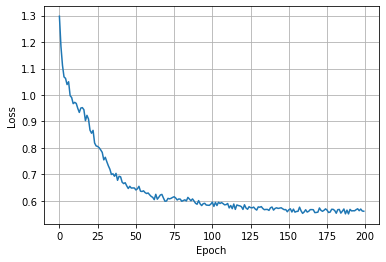

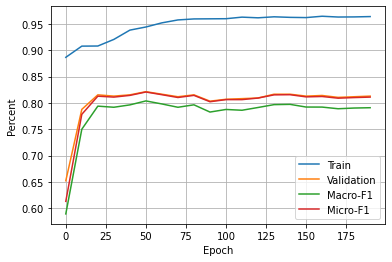

In [32]:
if True and __name__=="__main__":
    # _data = [ (torch.from_numpy(emb).float(), label) for emb,label in zip(xEmbeddingsScaled, yLabelsSmoothed) ]
    train_data = ListDataset([ ((torch.from_numpy(emb).float(), topic), label) for emb,topic,label in zip(xTrainEmbeddingsScaled, xTrainTopicsScaled, yTrain) ])
    val_data = ListDataset([ ((torch.from_numpy(emb).float(), topic), label) for emb,topic,label in zip(xValEmbeddingsScaled, xValTopicsScaled, yVal) ])
    model = MultiTaskMLP()
    summary(model, [(384,), (20,)], device='cpu')
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, weight_decay=2e-2)
    #optimizer = torch.optim.SGD(model.parameters(), lr=1)
    criterion = model.loss
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-1, epochs=200, steps_per_epoch=1)
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=(100, 150, 300), gamma=0.5)
    model = train_topicmtm(
        model_name = f"Multi-task MLP",
        model = model, 
        train_data = train_data,
        val_data = val_data,
        criterion = criterion,
        optimizer = optimizer, 
        #scheduler = scheduler,
        num_epochs = 200,
        batch_size = 1024,
        device = device,
        verbose = False, # False is still verbose, just less
    )

    # model.cpu()
    # x_val = torch.stack([ x for x,y in val_data ] )
    # y_val = torch.Tensor([ y for x,y in val_data ] )
    # macro_avg2 = 0
    # report = classification_report((y_val >= 0.5).int(), (torch.sigmoid(model(x_val)) >= 0.5).int(), output_dict=True)
    # macro_avg2 += report['macro avg']['f1-score']
    # print(macro_avg2)

## idk

In [15]:
X = np.array(xnpEmbeddings)
y = np.array([label.numpy() for label in yLabels])
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, 0.2)

NameError: name 'iterative_train_test_split' is not defined

In [147]:
# from collections import Counter
# from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
# pd.DataFrame({
#     'train': Counter(str(combination) for row in get_combination_wise_output_matrix(y_train, order=3) for combination in row),
#     'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(y_test, order=3) for combination in row)
# }).T.fillna(0.0
a, b, d, z = 0,0,0,0
for row in y_test:
    anx, dep, bip = row[0], row[1], row[2]
    if anx == 1: a += 1
    if bip == 1: b += 1
    if dep == 1: d += 1
    if anx==0 and bip == 0 and dep == 0: z += 1
print("count of anxiety, bipolar, depression, none:",a,b,d,z)
a, b, d, z = 0,0,0,0
for row in y_train:
    anx, dep, bip = row[0], row[1], row[2]
    if anx == 1: a += 1
    if bip == 1: b += 1
    if dep == 1: d += 1
    if anx==0 and bip == 0 and dep == 0: z += 1
print("count of anxiety, bipolar, depression, none:",a,b,d,z)

count of anxiety, bipolar, depression, none: 89 119 389 168
count of anxiety, bipolar, depression, none: 358 474 1555 683


## Main Model

In [ ]:
cs = ConvMLP_soft()
summary(cs, [ (384,), (10,) ], device='cpu')

In [12]:
def Training(train_data, val_data, n_topics=10):
    print(n_topics)
   #  # loss_params = {
   #  #     'task_alphas': (3.5,3.5,3.5), # BCEWithLogitsLoss per-task weighting
   #  #     'joint_beta': 0, # Focal Loss  overall weighting
   #  #     'focal_gamma': 2, # exponent in Focal Loss
   #  #     'reg_delta': 2, # soft-sharing regularization weighting
   #  #     'reg_epsilon': 0.000, # lasso regularization weighting
   #  # }
   #  loss_params = {
   #      'task_alphas': (2,0.5,1.8), # BCEWithLogitsLoss per-task weighting
   #      'joint_beta': 7., # Focal Loss  overall weighting
   #      'focal_gamma': 2, # exponent in Focal Loss
   #      'reg_delta': 2.5, # soft-sharing regularization weighting
   #      'reg_epsilon': 0.000, # lasso regularization weighting
   #  }
   #  # for rd in (0,1, 1.5, 2, 2.5, 3, 4):
   #  #     loss_params['reg_delta'] = rd
   #  #     for dr in (1, 0.9, 0.8, 0.6, 0.5):
   # # print("Training with", rd, dr)
   #  model = ConvMLP_soft(n_tasks=3, n_topics=n_topics, **loss_params)
   #  # model.load_state_dict(torch.load(HOME+"data/AllBalanced/ConvMLP-soft2.pt"))
   #  # model.joint_beta = nn.Parameter(torch.zeros(1), requires_grad=False); model.mtmreg_delta = nn.Parameter(torch.zeros(1), requires_grad=False); model.task_loss = nn.BCEWithLogitsLoss(weight=torch.Tensor([0,0,0]))
   #  # optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=3e-2)
   #  # criterion = model.calc_loss
   #  # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=8e-2, epochs=150, steps_per_epoch=1)
   #  optimizer = torch.optim.Adam(model.parameters(), lr=7e-3, weight_decay=7e-3)
   #  criterion = model.calc_loss
   #  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-1, epochs=170, steps_per_epoch=1)
   #  model, mets = train_topicmtm(
   #      model_name = str(type(model)),
   #      model = model, 
   #      train_data = train_data,
   #      val_data = val_data,
   #      criterion = criterion,
   #      optimizer = optimizer, 
   #      scheduler = scheduler,
   #      decay_reg = 0.8, # was 0.9
   #      num_epochs = 170,
   #      batch_size = 10000,
   #      num_workers = 0,
   #      device = device,
   #      verbose = False, # False is still verbose, just less
   #  )
   #  # if rd==0: break

    loss_params = {
        'task_alphas': (3.3,0.2,2.5),
        'joint_beta': 3,
        'focal_gamma': 2,
        'reg_delta': 0.,
        'reg_epsilon': 0.000,
    }
    model = ConvMLP_MTM(n_tasks=3, n_topics=n_topics, **loss_params)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=5e-3)
    criterion = model.calc_loss
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, epochs=80, steps_per_epoch=1)
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=(300,500), gamma=0.1)
    model, mets = train_topicmtm(
        model_name = str(type(model)),
        model = model, 
        train_data = train_data,
        val_data = val_data,
        criterion = criterion,
        optimizer = optimizer, 
        scheduler = scheduler,
        decay_reg = 1,
        num_epochs = 80,
        batch_size = 10000,
        num_workers = 0,
        device = device,
        verbose = False, # False is still verbose, just less
    )

    return model.state_dict(), mets

def KFoldTraining(data: list[tuple], n_folds=5, true_data=False):
    start_time = time.perf_counter()
    state_dicts = []; trainacc,valacc,f1mac,f1mic = 0,0,0,0
    print("Training on", int((1- 1/n_folds)*len(data)), "samples")
    kf_indices = KFold(n_splits=n_folds, shuffle=True).split(np.arange(len(data)))
    for fold_num, (train_idxs, val_idxs) in enumerate(kf_indices):
        _=f"[ FOLD {fold_num+1}/{n_folds} ]"; print(f"{_:~^80}")
        if true_data:
            print("Creating data...",end='\r')
            trainEmbeddings = emb_scaler.fit_transform([ data[i][0][0] for i in train_idxs ]); valEmbeddings = emb_scaler.transform([ data[i][0][0] for i in val_idxs ])
            _,trainTopics = topic_model.fit_transform([ docs[i] for i in train_idxs]); _,valTopics = topic_model.transform([ docs[i] for i in val_idxs ])
            trainLabels = [data[i][1] for i in train_idxs]; valLabels = [data[i][1] for i in val_idxs]
            state_dict,metrics = Training(
                train_data=ListDataset([ ((emb,top),label) for emb,top,label in zip(trainEmbeddings, trainTopics, trainLabels) ]), 
                val_data=ListDataset([ ((emb,top),label) for emb,top,label in zip(valEmbeddings, valTopics, valLabels) ]),
                n_topics=len(topic_model.get_topic_info())-1,
            )
        else:
            state_dict,metrics = Training(
                train_data=ListDataset([ data[i] for i in train_idxs ]), 
                val_data=ListDataset([ data[i] for i in val_idxs ]),
                n_topics=20,
            )
        state_dicts.append(copy.deepcopy(state_dict))
        trainacc += metrics[0]; valacc += metrics[1]; f1mac += metrics[2]; f1mic += metrics[3]
    print(f"Completed Fold Training in {(time.perf_counter()-start_time):.2f}s")
    return state_dicts, (trainacc/n_folds, valacc/n_folds, f1mac/n_folds, f1mic/n_folds)

def FoldlessTraining(data: list[tuple], trainvalsplit=0.8):
    splitIdx = int(len(data) * trainvalsplit); print("Training on", splitIdx, "samples")
    state_dict,metrics = Training(
        train_data=ListDataset(data[:splitIdx]), 
        val_data=ListDataset(data[splitIdx:]),
        n_topics=20,
    )
    return state_dict, metrics

## Execution

Training on 3043 samples
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[ FOLD 1/5 ]~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
20eating data...
Begining Training of <class '__main__.ConvMLP_MTM'>...


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Final Training Accuracy:	 93.10%
Final Validation Accuracy:	 87.74%
Final Unweighted Avg F1-score:	 78.75%
Final Weighted Avg F1-score:	 87.26%


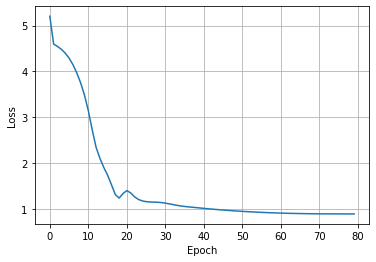

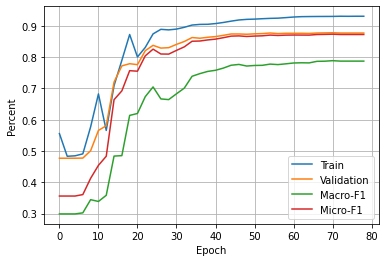

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[ FOLD 2/5 ]~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
20eating data...
Begining Training of <class '__main__.ConvMLP_MTM'>...


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Final Training Accuracy:	 94.59%
Final Validation Accuracy:	 87.65%
Final Unweighted Avg F1-score:	 79.80%
Final Weighted Avg F1-score:	 87.32%


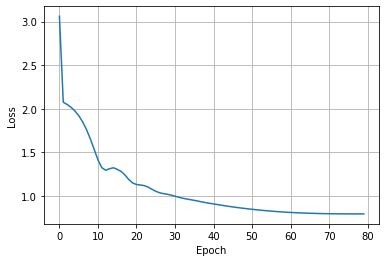

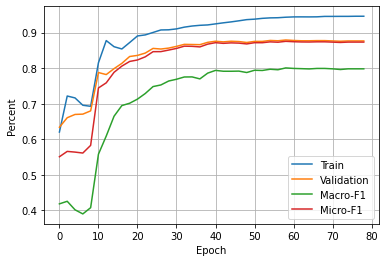

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[ FOLD 3/5 ]~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
20eating data...
Begining Training of <class '__main__.ConvMLP_MTM'>...


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Final Training Accuracy:	 92.98%
Final Validation Accuracy:	 85.85%
Final Unweighted Avg F1-score:	 77.04%
Final Weighted Avg F1-score:	 85.49%


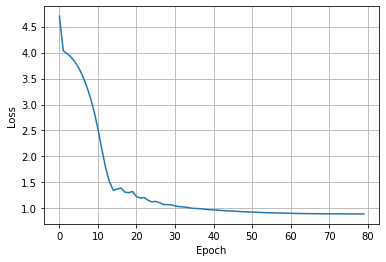

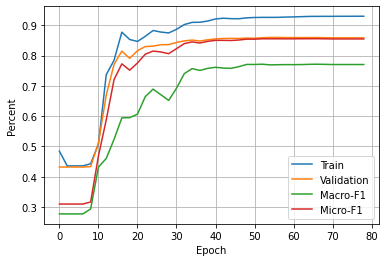

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[ FOLD 4/5 ]~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
20eating data...
Begining Training of <class '__main__.ConvMLP_MTM'>...


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Final Training Accuracy:	 93.34%
Final Validation Accuracy:	 87.82%
Final Unweighted Avg F1-score:	 78.90%
Final Weighted Avg F1-score:	 87.06%


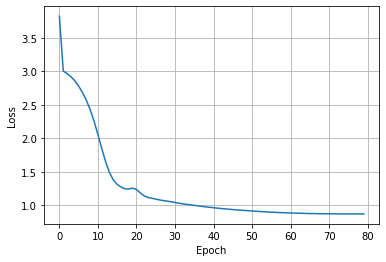

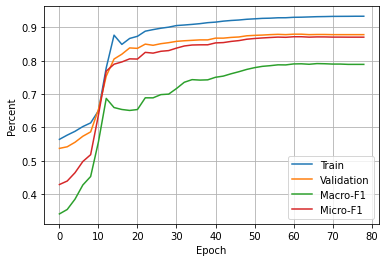

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[ FOLD 5/5 ]~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
20eating data...
Begining Training of <class '__main__.ConvMLP_MTM'>...


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Final Training Accuracy:	 96.47%
Final Validation Accuracy:	 87.76%
Final Unweighted Avg F1-score:	 78.92%
Final Weighted Avg F1-score:	 87.26%


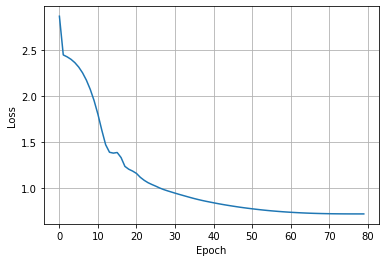

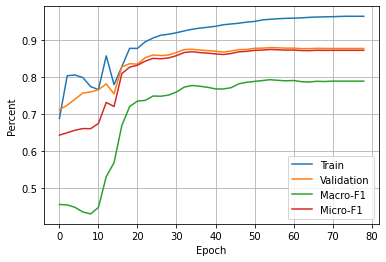

Completed Fold Training in 133.93s
(FINAL RESULTS)
Train Acc:	94.10%
Val Acc:	87.36%
Macro-F1:	78.68%
Micro-F1:	86.88%


In [160]:
if __name__=="__main__":
    # extras = [ torch.zeros(16) for topic in xTopics ]
    #extras = [  torch.cat((torch.from_numpy(topic), sent)) for topic, sent in zip(xTopics, xSentiment) ]
    extras = xTopics
    data = [ ((emb, extra), label) for (emb, extra, label) in zip(emb_scaler.fit_transform(xnpEmbeddings), extras, yLabelsSmoothed) ]
    # sd,met = FoldlessTraining(data)
    sd,met = KFoldTraining(data, true_data=True)
    print(f"(FINAL RESULTS)\nTrain Acc:\t{met[0]:.2%}\nVal Acc:\t{met[1]:.2%}\nMacro-F1:\t{met[2]:.2%}\nMicro-F1:\t{met[3]:.2%}")

# Evaluation

In [271]:
m = ConvMLP_soft(n_tasks=3, n_topics=20)
m.load_state_dict(torch.load(HOME+"data/AllBalanced/ConvMLP-soft1.pt"))
# m.load_state_dict(sd)
m.eval()
data = torch.load(HOME+"data/AllUnbalanced/SBERT_embeddings.pt")
xnpEmbeddings = [ emb.numpy() for emb,label in data ]
yLabels = [ label for emb,label in data ]

# raw_text = [ str(row['text']) for _,row in pd.read_excel(HOME+"data/RoccoShailikBalanced/dataset_2000.xlsx").iterrows() ]
raw_text = [ str(row['selftext'])+' '+str(row['title']) for _,row in pd.read_excel(HOME+"data/AllUnbalanced/dataset_3804.xlsx").iterrows() ]
processor = RBipolarDatasetBuilder(preprocess = light_preprocess, vectorizer = None)
topics, extras = topic_model.transform([processor.process_text(raw) for raw in raw_text])

data = [ ((emb, extra), label) for (emb, extra, label) in zip(emb_scaler.transform(xnpEmbeddings), extras, yLabels) ]
with torch.no_grad():
    (x,topic), gt = next(iter(torch.utils.data.DataLoader(data, batch_size=7000)))
    x = x.to(dtype=torch.float32).cpu()
    topic = topic.to(dtype=torch.float32).cpu()
    gt = (gt >= 0.5).to(dtype=torch.int32).transpose(0,1).cpu()
    
    output = torch.sigmoid(m(x, topic)).cpu()
    output = (output.transpose(0,1) >= 0.5).to(torch.int32)
    for task, name in enumerate(('anxiety', 'bipolar', 'depression')):
        task_output = output[task]
        task_gt = gt[task]
        print(f"{name:=^60}")
        print(classification_report(task_gt, task_output, digits=5))

==========================anxiety===========================
              precision    recall  f1-score   support

           0    0.89963   0.92155   0.91046      1313
           1    0.79482   0.74719   0.77027       534

    accuracy                        0.87114      1847
   macro avg    0.84722   0.83437   0.84036      1847
weighted avg    0.86933   0.87114   0.86993      1847

==========================bipolar===========================
              precision    recall  f1-score   support

           0    0.88810   0.85534   0.87141      1030
           1    0.82573   0.86414   0.84450       817

    accuracy                        0.85923      1847
   macro avg    0.85692   0.85974   0.85796      1847
weighted avg    0.86051   0.85923   0.85951      1847

=========================depression=========================
              precision    recall  f1-score   support

           0    0.89165   0.88651   0.88907      1216
           1    0.78370   0.79239   0.78802       631


# Case Study

### 9/3

In [4]:
root = "D:/Python/VTech/data/CaseStudy/"
data_df = pd.read_csv(root+"fullkeyphrases.csv")

In [14]:
t1 = to_unixtime(2000, 6)
t2 = to_unixtime(2020)
print(t2)

1577854800


In [21]:
# MONTHS ARE SEPARATED LAZILY
perMonth_ids = [ [] for i in range(24) ]
for (i,row) in tqdm(data_df.iterrows(), total=78262):
    time = row['created_utc']
    # print(to_clocktime(row['created_utc']))
    idx = (time-1577854800)//2628000
    perMonth_ids[idx].append(i)
    

  0%|          | 0/78262 [00:00<?, ?it/s]

In [31]:
perMonth_bigstr = [None] * 24
for i,month in tqdm(enumerate(perMonth_ids)):
    big_list = [ str(data_df.iloc[i]['title'])+' '+str(data_df.iloc[i]['selftext']) for i in month]
    big_string = ' '.join(big_list)
    perMonth_bigstr[i] = big_string

0it [00:00, ?it/s]

In [73]:
percluster_keywords = []
for ids in tqdm(perMonth_ids, desc="Clusters"):
    keyphrasesL = []
    for id in ids:
        keyphrasesL.append(eval(data_df.iloc[id]['MultipartiteRank'])[:3])
    
    total_keyphrases = {}
    for doc_keys in keyphrasesL:
        for phrase, score in doc_keys:
            if phrase in total_keyphrases:
                total_keyphrases[phrase][0] += score
                total_keyphrases[phrase][1] += 1
            else:
                total_keyphrases[phrase] = [score, 1]
    
    # kw = sorted(total_keyphrases.keys(), key=lambda x: total_keyphrases[x], reverse=True)
    percluster_keywords.append(total_keyphrases)

Clusters:   0%|          | 0/24 [00:00<?, ?it/s]

In [18]:
df = pd.read_csv(root+"fullkeyphrases.csv")
tot_kw = [dict() for i in range(8)]
for i,row in tqdm(df.iterrows(), total=78262):
    kwss = eval(row['MultipartiteRank'])
    kws = [pair[0] for pair in kwss]
    cluster_id = row['cluster_id']
    for kp in kws:
        if kp in tot_kw[cluster_id]:
            tot_kw[cluster_id][kp] += 1
        else:
            tot_kw[cluster_id][kp] = 1

  0%|          | 0/78262 [00:00<?, ?it/s]

In [21]:
cluster_ranks = []
for cluster in range(8):
    kw_dict = tot_kw[cluster]
    kw_list = list(kw_dict.keys())
    ranked = sorted(kw_list, key=lambda kw: kw_dict[kw], reverse=True)
    cluster_ranks.append(ranked)

In [22]:
for cluster in range(8):
    print(cluster_ranks[cluster][:20])

['people', 'meds', 'bipolar', 'manic', 'today', 'years', 'day', 'time', 'guys', 'things', 'mania', 'days', 'life', 'months', 'help', 'good', 'advice', 'lamictal', 'way', 'lithium']
['depression', 'life', 'depressed', 'people', 'time', 'years', 'things', 'today', 'day', 'better', 'help', 'way', 'days', 'good', 'happy', 'sad', 'meds', 'months', 'friends', 'depressive episode']
['bipolar', 'meds', 'manic', 'people', 'mania', 'years', 'bipolar disorder', 'lithium', 'months', 'lamictal', 'time', 'doctor', 'seroquel', 'day', 'days', 'psychiatrist', 'medication', 'things', 'weeks', 'guys']
['bipolar', 'years', 'depression', 'meds', 'life', 'people', 'manic', 'time', 'months', 'things', 'depressed', 'mania', 'day', 'days', 'medication', 'weeks', 'help', 'happy', 'good', 'better']
['people', 'time', 'things', 'anxiety', 'scared', 'today', 'job', 'work', 'years', 'day', 'way', 'sure', 'days', 'months', 'advice', 'hours', 'help', 'guys', 'life', 'friends']
['job', 'life', 'people', 'years', 'day'

In [4]:
root = "D:/Python/VTech/data/CaseStudy/"
full_dataset = pd.read_csv(HOME+"data/CaseStudy/dataset_78262.csv")
raw_texts = [ str(row['title'])+" "+str(row['selftext']) for i,row in full_dataset.loc[:,['selftext','title']].iterrows() ]
processed_texts = [ light_preprocess(raw_text) for raw_text in raw_texts ]
fullprocessed_texts = [ full_preprocess(text, join=True) for text in processed_texts ]

## Predictions

In [ ]:
model = ConvMLP_soft(n_tasks=3, n_topics=20)
model.load_state_dict(torch.load(HOME+"data/AllBalanced/ConvMLP-soft1.pt"))
model = model.to(device)
model.eval()
embs = [emb.cpu().numpy() for emb in torch.load(HOME+"data/CaseStudy/SBERT_embeddings.pt")]
embs = [torch.from_numpy(emb).to(device) for emb in emb_scaler.transform(embs) ]
#embs = torch.load(HOME+"data/CaseStudy/SBERT_embeddings.pt")
processor = RBipolarDatasetBuilder(preprocess = light_preprocess, vectorizer = None)
_,topic_vecs = topic_model.transform([ processor.process_text(raw) for raw_text in raw)
topic_vecs = [torch.from_numpy(tv).to(device) for tv in topic_vecs]

In [347]:
preds = []
loader = torch.utils.data.DataLoader(list(zip(embs, topic_vecs)), batch_size=5000)
with torch.no_grad():
    for emb, tv in tqdm(loader):
        #_,topic_vec = topic_model.transform(doc); topic_vec = torch.from_numpy(topic_vec)#.to(device=device)
        pred = torch.sigmoid(model(emb.to(torch.float32), tv.to(torch.float32))).cpu()
        preds.append(pred)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 26.28it/s]


In [352]:
allpreds = torch.concat(preds, dim=0)

In [354]:
torch.save(allpreds, HOME+"data/CaseStudy/soft1preds.pt")

In [361]:
print(raw[2050])
print(allpreds[2050])

HAVING MANIA IS NOT “FUN” [removed]
tensor([0.0796, 0.3308, 0.1926])


## Sentiments

In [399]:
# negative, neutral, positive
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig, BatchEncoding
from scipy.special import softmax
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)

sentiments = []
pbar = tqdm(raw)
try:
    for text in pbar:
        text = light_preprocess(text)
        encoded_input = BatchEncoding(tokenizer(text, max_length=512, return_tensors='pt')).to(device)
        output = model(**encoded_input)
        sent = torch.softmax(output['logits'][0], 0).detach().cpu()
        sentiments.append(sent)
finally:
    pbar.close()

100%|████████████████████████████████████████████████████████████████████████████| 78262/78262 [21:23<00:00, 60.97it/s]


In [400]:
torch.save(sentiments, HOME+"data/CaseStudy/RoBERTa-Twitter_sentiments.pt")

In [401]:
# pipe = pipeline('sentiment-analysis', model="cardiffnlp/twitter-roberta-base-sentiment-latest")
pipe = pipeline('text-classification', model='bhadresh-savani/bert-base-uncased-emotion', top_k=6, device=device)

sentimentMaps = []
for text in tqdm(raw):
    preds = pipe(text, max_length=512, truncation=True)
    sentimentMaps.append(preds)

100%|████████████████████████████████████████████████████████████████████████████| 78262/78262 [17:26<00:00, 74.75it/s]


In [402]:
# joy, sadness, anger, fear, surprise, love
sentimentMaps = [ {map['label']:map['score'] for map in pred[0]} for pred in sentimentMaps ]
xSentiment = [ torch.Tensor([s['joy'],s['sadness'],s['anger'],s['fear'],s['surprise'],s['love']]) for s in sentimentMaps]

In [410]:
torch.save(xSentiment, HOME+"data/CaseStudy/BERT_emotions.pt")

## Topic Modeling

In [167]:
topic_model = BERTopic(calculate_probabilities=True, min_topic_size=40, verbose=True)
topic_data = []
tm_topics, prob_vecs = topic_model.fit_transform(fullprocessed_texts)

Batches:   0%|          | 0/2446 [00:00<?, ?it/s]

2023-08-09 15:47:20,416 - BERTopic - Transformed documents to Embeddings
2023-08-09 15:47:46,904 - BERTopic - Reduced dimensionality
2023-08-09 15:50:47,307 - BERTopic - Clustered reduced embeddings


In [197]:
print(topics)

[[9.99999998e-001 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [2.22027702e-001 2.56660128e-003 1.15901547e-003 ... 6.25765230e-004
  6.24240702e-004 8.55691856e-004]
 [4.35637293e-001 5.39663076e-216 6.10863065e-216 ... 1.19193817e-224
  7.99112404e-225 1.81880621e-002]
 ...
 [9.52943081e-001 6.63178928e-003 4.17478769e-003 ... 9.18572623e-004
  8.33627681e-004 3.12930121e-003]
 [1.03028312e-001 3.46281520e-010 3.44262813e-009 ... 2.03371198e-012
  1.87326129e-012 2.80589074e-011]
 [9.99999998e-001 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]]


In [172]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,35756,-1_like_feel_know_bipolar,"[like, feel, know, bipolar, time, get, want, d...",[life constantly crumbling abuser fucking made...
1,0,40588,0_like_feel_bipolar_get,"[like, feel, bipolar, get, know, time, anyone,...",[clue going rant literally human provide sligh...
2,1,349,1_episode_mixed_hypomanic_like,"[episode, mixed, hypomanic, like, long, anyone...","[mixed episode, mixed episode, mixed episode]"
3,2,191,2_relationship_girlfriend_dating_partner,"[relationship, girlfriend, dating, partner, bo...","[relationship, relationship, relationship]"
4,3,159,3_advice_need_looking_please,"[advice, need, looking, please, help, advise, ...","[advice, advice, advice]"
5,4,141,4_stable_stability_unstable_long,"[stable, stability, unstable, long, lockdown, ...","[stable, stable, stable]"
6,5,107,5_cooking_breakfast_pancake_pepper,"[cooking, breakfast, pancake, pepper, cooked, ...",[year eating fast food cooking made steak firs...
7,6,92,6_rapid_cycling_cycle_vicious,"[rapid, cycling, cycle, vicious, cycler, ultra...","[rapid cycling, rapid cycling, rapid cycling]"
8,7,86,7_latuda_experience_anyone_esta,"[latuda, experience, anyone, esta, afford, vra...","[latuda, latuda, latuda]"
9,8,77,8_related_discussion_med_mega,"[related, discussion, med, mega, monday, threa...",[med monday mega thread med related discussion...


In [171]:
topic_model.reduce_topics(fullprocessed_texts, nr_topics='auto')

2023-08-09 15:51:44,851 - BERTopic - Reduced number of topics from 110 to 23


In [176]:
topics, prob_vecs = topic_model.transform(fullprocessed_texts)

Batches:   0%|          | 0/2446 [00:00<?, ?it/s]

2023-08-09 15:55:12,503 - BERTopic - Reduced dimensionality
2023-08-09 15:58:33,495 - BERTopic - Calculated probabilities with HDBSCAN
2023-08-09 15:58:33,495 - BERTopic - Predicted clusters


(78262, 22)


In [177]:
torch.save(prob_vecs, HOME+"data/CaseStudy/topics22.pt")

## Keyphrase Extraction

### Clustering

In [7]:
preds = torch.load(root+"soft1preds.pt")
# sents = torch.load(root+"RoBERTa-Twitter_sentiments.pt")
sents = torch.load(root+"BERT_emotions.pt")
topics = torch.load(root+"topics22.pt")

In [8]:
print(preds.shape)
print((preds[0] >= 0.5).sum(), (preds[1] >= 0.5).sum(), (preds[2] >= 0.5).sum())

torch.Size([78262, 3])
tensor(1) tensor(0) tensor(0)


In [9]:
X = torch.concat( (preds,sents[:,[0,2]]), dim=1).to(torch.float64) # positive & negative OR joy and anger

In [10]:
n_clusters = 30
# clustering = MiniBatchKMeans(n_clusters=n_clusters, init="k-means++", batch_size=2048,max_iter=1000)
# clustering = HDBSCAN(min_cluster_size=30, min_samples=100,max_cluster_size=10000,cluster_selection_epsilon=0, n_jobs=-1)
# clustering = OPTICS(min_samples=5, max_eps=0.1, min_cluster_size=30, n_jobs=-1)
clustering = Birch(threshold=0.33, n_clusters=None)
# clustering = GaussianMixture()

In [10]:
one_hots = (preds >= 0.5).to(torch.int)
n_clusters = 8
combination_ids = {
    (0,0,0):0,
    (0,0,1):1,
    (0,1,0):2,
    (0,1,1):3,
    (1,0,0):4,
    (1,0,1):5,
    (1,1,0):6,
    (1,1,1):7,
}
clusters = [ combination_ids[tuple(preds.tolist())] for preds in one_hots ]

# per cluster: concat reviews to one big string
# then separate into months and extract

In [11]:
clusters = clustering.fit_predict(X)

In [16]:
n_clusters = 10
clustered_texts = [ [] for _ in range(n_clusters)]
clustered_texts_textids = [ [] for _ in range(n_clusters) ]
outliers = []
for text_id, (text, cluster_id) in enumerate(zip(processed_texts, clusters)):
    if cluster_id >= 0:
        clustered_texts[cluster_id].append(text)
        clustered_texts_textids[cluster_id].append(text_id)
    else:
        outliers.append(text)
print(len(outliers), "outliers")
print("Cluster sizes:")
for c in clustered_texts:
    print(len(c))

0 outliers
Cluster sizes:
16680
4675
20886
10620
8492
3205
3560
3252
3419
3473


### Extraction

In [149]:
cluster_topicavgs = [ np.mean([topics[id] for id in cluster_ids ], axis=1) 
                        for cluster_ids in clustered_texts_textids ]

In [150]:
for topicavg in cluster_topicavgs:
    top_topics = sorted(range(1,23), key=(lambda t: topicavg[t-1]), reverse=True)
    print(top_topics)

[4, 3, 22, 14, 21, 6, 2, 7, 10, 17, 5, 8, 12, 13, 16, 19, 15, 1, 18, 11, 9, 20]
[3, 16, 19, 2, 10, 20, 14, 4, 11, 1, 21, 13, 22, 7, 12, 15, 5, 18, 17, 8, 6, 9]
[7, 13, 9, 1, 17, 14, 12, 22, 19, 8, 21, 11, 18, 20, 6, 2, 15, 16, 4, 5, 10, 3]
[10, 11, 19, 2, 12, 18, 17, 13, 4, 5, 6, 8, 9, 15, 3, 21, 1, 20, 14, 7, 22, 16]
[11, 19, 1, 3, 8, 7, 10, 15, 13, 5, 14, 22, 6, 2, 21, 4, 16, 9, 17, 20, 12, 18]
[11, 12, 6, 22, 3, 17, 8, 9, 19, 5, 2, 18, 14, 13, 15, 21, 7, 1, 4, 16, 10, 20]
[4, 11, 16, 15, 3, 13, 14, 2, 6, 1, 12, 7, 20, 8, 9, 5, 18, 17, 22, 19, 10, 21]
[10, 16, 15, 4, 9, 20, 13, 1, 2, 22, 21, 8, 7, 6, 12, 17, 5, 11, 19, 18, 14, 3]
[5, 7, 19, 11, 10, 1, 4, 15, 6, 22, 16, 17, 20, 18, 14, 13, 9, 3, 12, 21, 8, 2]
[1, 5, 12, 3, 8, 4, 15, 2, 6, 21, 20, 9, 10, 11, 22, 19, 13, 7, 14, 16, 17, 18]


In [34]:
from utils import en_stopwords, reddit_words
spacy.require_gpu()
nlp = spacy.load("en_core_web_sm")

all_keyphrases = []
extractor = pke.unsupervised.MultipartiteRank()
for doc in tqdm(nlp.pipe(processed_texts), total=len(processed_texts), unit='docs'):
    extractor.load_document(input=doc, language='en', normalization=None, stoplist=en_stopwords.union(reddit_words))

    extractor.candidate_selection()
    extractor.candidate_weighting()
    keyphrases = extractor.get_n_best(n=10)
    all_keyphrases.append(keyphrases)

  0%|          | 0/78262 [00:00<?, ?docs/s]

In [17]:
from utils import en_stopwords, reddit_words
spacy.require_gpu()
nlp = spacy.load('en_core_web_sm')

percluster_keywords = []
extractor = pke.unsupervised.MultipartiteRank()
for texts in tqdm(clustered_texts, desc="Clusters"):
    keyphrasesL = []
    for doc in tqdm(nlp.pipe(texts), total=len(texts), desc="Current Cluster", leave=False, unit='docs'):
        # doc = [ tuple(full_preprocess(text)) for text in texts]
        extractor.load_document(input=doc, language='en', normalization=None, stoplist=en_stopwords.union(reddit_words))
        # # Yake
        # extractor.candidate_selection()#n=5)
        # extractor.candidate_weighting(window=2,use_stems=True)
        # keyphrases = extractor.get_n_best(n=3)#, threshold=0.8)
        # # singlerank
        # extractor.candidate_selection()#n=5)
        # extractor.candidate_weighting(window=2,use_stems=True)
        # keyphrases = extractor.get_n_best(n=3)#, threshold=0.8)
        # multipartiterank
        extractor.candidate_selection()#n=5)
        extractor.candidate_weighting()
        keyphrases = extractor.get_n_best(n=3)#, threshold=0.8)
        keyphrasesL.append(keyphrases)
        
    total_keyphrases = {}
    for doc_keys in keyphrasesL:
        for phrase, score in doc_keys:
            if phrase in total_keyphrases:
                total_keyphrases[phrase][0] += score
                total_keyphrases[phrase][1] += 1
            else:
                total_keyphrases[phrase] = [score, 1]
    
    # kw = sorted(total_keyphrases.keys(), key=lambda x: total_keyphrases[x], reverse=True)
    percluster_keywords.append(total_keyphrases)

Clusters:   0%|          | 0/10 [00:00<?, ?it/s]

Current Cluster:   0%|          | 0/16680 [00:00<?, ?docs/s]

Current Cluster:   0%|          | 0/4675 [00:00<?, ?docs/s]

Current Cluster:   0%|          | 0/20886 [00:00<?, ?docs/s]

Current Cluster:   0%|          | 0/10620 [00:00<?, ?docs/s]

Current Cluster:   0%|          | 0/8492 [00:00<?, ?docs/s]

Current Cluster:   0%|          | 0/3205 [00:00<?, ?docs/s]

Current Cluster:   0%|          | 0/3560 [00:00<?, ?docs/s]

Current Cluster:   0%|          | 0/3252 [00:00<?, ?docs/s]

Current Cluster:   0%|          | 0/3419 [00:00<?, ?docs/s]

Current Cluster:   0%|          | 0/3473 [00:00<?, ?docs/s]

In [74]:
kw_freqs = dict()
for kws in percluster_keywords:
    kws = sorted(kws.items(), key=lambda kw: kw[1][0], reverse=True)[:50]
    for kw, (score,freq) in kws:
        if kw not in kw_freqs:
            kw_freqs[kw] = 1
        else:
            kw_freqs[kw] += 1
# cluster_kwfreqs = []
# for kws in percluster_keywords:
#     tot = 0
#     for tot_score, tot_votes in kws.values():
#         tot += tot_votes
#     freqs = {}
#     for kw, (score, votes) in kws.items():
#         freqs[kw] = math.sqrt(votes/tot)
#     cluster_kwfreqs.append(freqs)

In [189]:
corpus_inversekwfreqs = {}
for kws in cluster_kwfreqs:
    for kw, prop in kws.items():
        if kw not in corpus_inversekwfreqs:
            corpus_inversekwfreqs[kw] = prop
        else:
            corpus_inversekwfreqs[kw] += prop

In [76]:
percluster_unique_kws = []
n_clusters = 24
exclusion_threshold = int(1* n_clusters)
# for kwfreq_map in cluster_kwfreqs:
    # sortbyunique = sorted(kwfreq_map.keys(), key=lambda kw: kwfreq_map[kw] / corpus_inversekwfreqs[kw], reverse=True)
    # sortbyunique = sorted(kwfreq_map.items(), key=lambda kw: kwfreq_map[kw[0]] / corpus_inversekwfreqs[kw[0]], reverse=True)

for kws in percluster_keywords:
    sortbyunique = sorted(kws.keys(), key=lambda kw: kws[kw][1]*(1 if (kw not in kw_freqs) or (kw in kw_freqs and kw_freqs[kw] <= exclusion_threshold) else 0), reverse=True)
    # sortbyunique = sorted(kws.items(), key=lambda kw: kw[1][1]*(1 if (kw[0] not in kw_freqs) or (kw[0] in kw_freqs and kw_freqs[kw[0]] < exclusion_threshold) else 0), reverse=True)
    percluster_unique_kws.append(sortbyunique)

for kws in percluster_unique_kws:
    print(kws[:10])

['bipolar', 'years', 'people', 'manic', 'meds', 'life', 'mania', 'months', 'guys', 'day']
['bipolar', 'meds', 'people', 'years', 'months', 'mania', 'day', 'manic', 'life', 'time']
['bipolar', 'meds', 'people', 'day', 'manic', 'years', 'time', 'life', 'days', 'today']
['bipolar', 'meds', 'people', 'years', 'manic', 'time', 'things', 'day', 'life', 'help']
['bipolar', 'years', 'people', 'meds', 'today', 'mania', 'day', 'time', 'lamictal', 'manic']
['bipolar', 'people', 'meds', 'manic', 'years', 'things', 'life', 'time', 'mania', 'months']
['bipolar', 'people', 'meds', 'mania', 'manic', 'years', 'life', 'things', 'time', 'months']
['bipolar', 'people', 'years', 'meds', 'time', 'life', 'manic', 'months', 'things', 'day']
['bipolar', 'people', 'years', 'life', 'meds', 'things', 'today', 'mania', 'depression', 'manic']
['bipolar', 'years', 'people', 'meds', 'manic', 'time', 'things', 'mania', 'life', 'day']
['bipolar', 'people', 'years', 'meds', 'time', 'manic', 'things', 'day', 'life', 'dep